<a href="https://colab.research.google.com/github/amFarrouk/OCR_prj/blob/main/simpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile

In [2]:
!wget https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
!unzip -qq ./bdh.zip 
!rm ./bdh.zip

--2021-12-06 02:31:51--  https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7536168 (7.2M) [application/zip]
Saving to: ‘bdh.zip’

bdh.zip             100%[===================>]   7.19M  --.-KB/s    in 0.1s    

2021-12-06 02:31:52 (71.6 MB/s) - ‘bdh.zip’ saved [7536168/7536168]



In [3]:
!wget https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv

--2021-12-06 02:31:53--  https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpagi0h1089kr2f/images_df.csv [following]
--2021-12-06 02:31:54--  https://www.dropbox.com/s/raw/qpagi0h1089kr2f/images_df.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc73ae5d7ae4afc6784f58cd4572.dl.dropboxusercontent.com/cd/0/inline/BbRmLhYpVcFINIanQ5oClZBqfcGLKyTvX8ZBzIdhf1yv-pM661Rc3IsA_9Hk9hLhPd3VVrFptb4Oo6y10etuzSVj2amIPxJkqfilHNyAdlSu2g2Hcm8IV-h3rMxyA0i7ifPgVIq2oj6zcy_8dTaOE908/file# [following]
--2021-12-06 02:31:54--  https://uc73ae5d7ae4afc6784f58cd4572.dl.dropboxusercontent.com/cd/0/inline/BbRmLhYpVcFINIanQ5oClZBqfcGLKyTvX8ZBzIdhf1yv-pM661Rc3IsA_9Hk9hLhPd3VVrFptb4Oo6y10etu

In [4]:
images_df=pd.read_csv("./images_df.csv",header=None,names=["img","label"])
images_df["label"]=images_df["label"].apply(lambda x : str(x))
images_df.head()

,img,label
0,ae07_005.bmp,18
1,ae07_011.bmp,17
2,ae07_014.bmp,20
3,ae07_015.bmp,18
4,ae07_022.bmp,12


In [5]:
labels=images_df['label']
labels=labels.to_numpy()

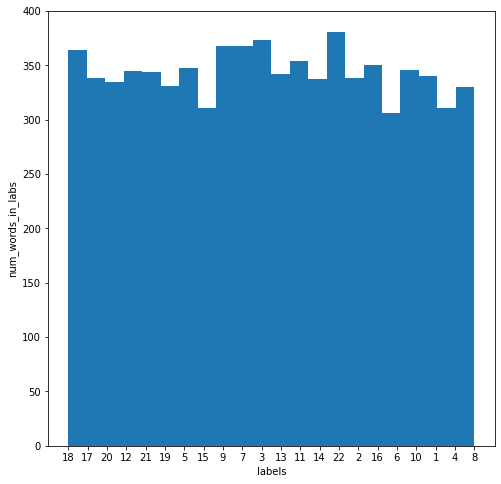

In [6]:
plt.figure(figsize=(8,8))
plt.xlim()
plt.xlabel("labels")
plt.ylabel("num_words_in_labs")
plt.hist(labels,bins=22)
plt.show()

In [7]:
img=cv2.imread("./bdh/ae07_005.bmp",cv2.IMREAD_GRAYSCALE)
img.shape

(114, 499)

In [8]:
imgresize = cv2.resize(img, (760, 120)) 

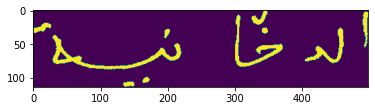

In [9]:
plt.imshow(img)

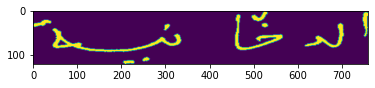

In [10]:
plt.imshow(imgresize)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
all_x,all_y=images_df["img"],images_df["label"]

xtrain,xtest,ytrain,ytest=train_test_split(all_x,all_y,train_size=0.8,random_state=1,shuffle=True)

train_df=pd.DataFrame(xtrain,columns=["img"])
train_df["label"]=ytrain

print("train_data:")
train_df.head()

train_data:


,img,label
5764,de12_032.bmp,16
7223,dm34_024.bmp,16
5124,cj14_066.bmp,13
5621,cq65_006.bmp,8
2624,bi06_006.bmp,16


In [13]:
test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

print("test_data:")
test_df.head()

test_data:


,img,label
3069,bj01_033.bmp,3
642,af62_017.bmp,22
7266,dq06_018.bmp,8
5765,de12_034.bmp,16
2229,be92_023.bmp,13


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_image_gen=ImageDataGenerator(rescale=1.0/255)
test_image_gen=ImageDataGenerator(rescale=1.0/255)

In [16]:
train_image_gen=train_image_gen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(imgresize.shape[0],imgresize.shape[1]),
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 6048 validated image filenames belonging to 22 classes.


In [17]:
test_image_gen=test_image_gen.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(imgresize.shape[0],imgresize.shape[1]),
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 1512 validated image filenames belonging to 22 classes.


In [18]:
import tensorflow as tf

In [19]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 760x120 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(760, 120, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 64 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22, activation='softmax')
])

In [20]:
loss=tf.keras.losses.categorical_crossentropy
optim=tf.keras.optimizers.Adam()

In [21]:
model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 758, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 379, 59, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 377, 57, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 188, 28, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 26, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 93, 13, 64)       0

In [23]:
history=model.fit(train_image_gen,epochs=100,steps_per_epoch=189,validation_data=test_image_gen)

Epoch 1/100
189/189 [==============================] - 44s 162ms/step - loss: 0.6711 - accuracy: 0.8084 - val_loss: 0.2852 - val_accuracy: 0.9021
Epoch 2/100
189/189 [==============================] - 30s 160ms/step - loss: 0.0569 - accuracy: 0.9810 - val_loss: 0.2903 - val_accuracy: 0.9081
Epoch 3/100
189/189 [==============================] - 30s 160ms/step - loss: 0.0305 - accuracy: 0.9901 - val_loss: 0.3214 - val_accuracy: 0.9246
Epoch 4/100
189/189 [==============================] - 30s 160ms/step - loss: 0.0216 - accuracy: 0.9916 - val_loss: 0.2834 - val_accuracy: 0.9325
Epoch 5/100
189/189 [==============================] - 30s 159ms/step - loss: 0.0257 - accuracy: 0.9902 - val_loss: 0.2214 - val_accuracy: 0.9458
Epoch 6/100
189/189 [==============================] - 30s 159ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.2468 - val_accuracy: 0.9431
Epoch 7/100
189/189 [==============================] - 30s 160ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.2453 -